In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
%matplotlib inline

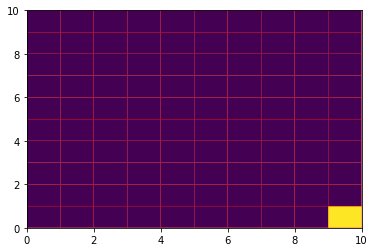

In [2]:
nrow, ncol = 10,10
R1 = [[0 for _ in range(nrow)] for _ in range(ncol)]
R1[9][9] = 1
plt.pcolor(np.flipud(R1), edgecolors='red')

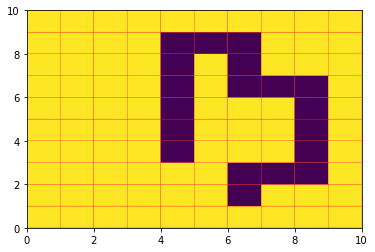

In [3]:
R2 = [[0 for _ in range(nrow)] for _ in range(ncol)]
indices = [(1,4),(1,5),(1,6),(2,4),(2,6),(3,4),(3,6),(3,7),(3,8),(4,4),(4,8),
          (5,4),(5,8),(6,4),(6,8),(7,6),(7,7),(7,8),(8,6)]
for (i,j) in indices:
    R2[i][j] = -100
plt.pcolor(np.flipud(R2), edgecolors='red')

In [4]:
states = [(i,j) for i in range(10) for j in range(10)]
actions = ['up', 'down', 'left', 'right']
arrows = [u'\u2191',u'\u2193',u'\u2190',u'\u2192']
gamma = 0.8
w = 0.1

In [5]:
def edge_state(state):
    (i,j) = state
    if ((i==0 or i==9) and j in range(1,9)) or (i in range(1,9) and (j==0 or j==9)):
        return True
    else:
        return False
    
corner_state = lambda state: state in [(0,0),(0,9),(9,0),(9,9)]

In [6]:
def neighbors(current_state):
    (i,j) = current_state
    if corner_state(current_state):
        if current_state == (0,0):
            return [(i,j),(i,j+1),(i+1,j)]
        elif current_state == (0,9):
            return [(i,j),(i,j-1),(i+1,j)]
        elif current_state == (9,0):
            return [(i,j),(i,j+1),(i-1,j)]
        else:
            return [(i,j),(i,j-1),(i-1,j)]
    elif edge_state(current_state):
        if i==0:
            return [(i,j),(i+1,j),(i,j-1),(i,j+1)]
        elif j==0:
            return [(i-1,j),(i+1,j),(i,j),(i,j+1)]
        elif i==9:
            return [(i-1,j),(i,j),(i,j-1),(i,j+1)]
        elif j==9:
            return [(i-1,j),(i+1,j),(i,j-1),(i,j)]
    else:
        return [(i-1,j),(i+1,j),(i,j-1),(i,j+1)]

In [7]:
def off_grid(state,action):
    (i,j) = state
    if (i==0 and action=='up') or (i==9 and action =='down') or (j==0 and action =='left') or (j==9 and action=='right'):
        return True
    else: 
        return False

In [8]:
def trans_prob(current_state,next_state,action):
    (i,j) = current_state
    neigh = neighbors(current_state)
    directions = ['up','down','left','right']
    if corner_state(current_state):
        if off_grid(current_state,action):
            prob = [1-w+w/4+w/4,w/4, w/4]
        else:
            prob = [w/4+w/4,w/4,w/4] #Initialize all three probs and change one of the probs based on the direction and position
            if (j==0 and action == 'right') or (j==9 and action == 'left'):
                prob[1] = 1-w+w/4
            elif (i==0 and action == 'down') or (i==9 and action == 'up'):
                prob[2] = 1-w+w/4
    else: #This else takes care of both the edges and the middle cases
        prob = [w/4,w/4,w/4,w/4]
        prob[directions.index(action)] = 1-w+w/4
    if next_state in neigh:
        p = prob[neigh.index(next_state)]
    else:
        p = 0
    return p

In [9]:
def reward(next_state,reward_function):
    (i,j) = next_state
    return reward_function[i][j]

In [10]:
def value_iteration_estimation(reward_function,plots=True):
    V = [[0 for _ in range(nrow)] for _ in range(ncol)]
    delta = 1e10
    eps = 0.01
    while delta>eps:
        delta = 0
        for current_state in states:
            temp = V[current_state[0]][current_state[1]]
            max_prv = -1e10
            for action in actions:
                prv = 0
                for next_state in neighbors(current_state):
                    P = trans_prob(current_state,next_state,action)
                    R = reward(next_state,reward_function)
                    (i,j) = next_state
                    next_v = V[i][j]
                    prv += P*(R+gamma*next_v)
                if prv>max_prv:
                    max_prv = prv
            V[current_state[0]][current_state[1]] = max_prv
            delta = np.maximum(delta,np.absolute(temp-V[current_state[0]][current_state[1]]))
    if plots:
        plt.pcolor(np.flipud(V), edgecolors='red')
        plt.colorbar()
        plt.xticks(np.arange(ncol))
        plt.yticks(np.arange(nrow))    
        plt.title('Heat map of the optimal state values')
        plt.show()

        fig = plt.figure()
        ax = fig.gca()
        im = ax.imshow(reward_function)
        for i in range(nrow):
            for j in range(ncol):
                text = ax.text(j, i, round(V[i][j],2), ha="center", va="center", color="w")
        ax.set_xticks(np.arange(ncol))
        ax.set_yticks(np.arange(nrow))  
    return V

In [11]:
def value_iteration_computation(reward_function,V, plots = True):
    pi = [[0 for _ in range(nrow)] for _ in range(ncol)]
    for current_state in states:
        prv_vals = []
        for action in actions:
            prv = 0
            for next_state in neighbors(current_state):
                    P = trans_prob(current_state,next_state,action)
                    R = reward(next_state,reward_function)
                    (i,j) = next_state
                    next_v = V[i][j]
                    prv += P*(R+gamma*next_v)
            prv_vals.append(prv)
        pi[current_state[0]][current_state[1]] = np.argmax(prv_vals)
    if plots:
        fig = plt.figure()
        ax = fig.gca()    
            
            #if reward_function == 'R1':
            #    im = ax.imshow(R1)
            #else:
            #    im = ax.imshow(R2)
        im = ax.imshow(reward_function)
        for i in range(nrow):
            for j in range(ncol):
                text = ax.text(j, i, arrows[pi[i][j]], ha="center", va="center", color="r")
        ax.set_xticks(np.arange(ncol))
        ax.set_yticks(np.arange(nrow))
    return pi

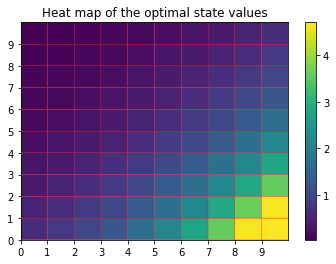

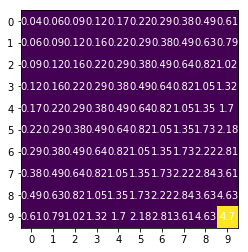

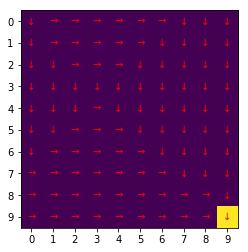

In [12]:
V = value_iteration_estimation(R1)
pi_R1 = value_iteration_computation(R1,V)

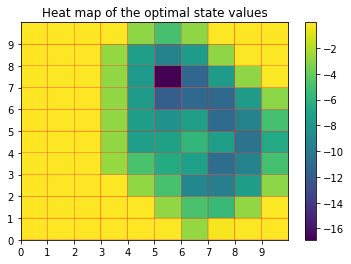

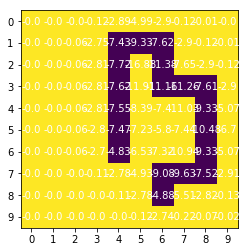

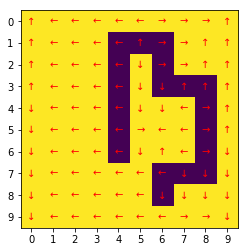

In [13]:
V = value_iteration_estimation(R2)
pi_R2 = value_iteration_computation(R2,V)

In [14]:
def trans_prob_matrix(pi,add=0):
    tp_matrix = np.zeros((len(states),len(states)))
    for row in range(len(states)):
        for col in range(len(states)):
            (j,i) = divmod(row,10)
            (l,k) = divmod(col,10)
            tp_matrix[row,col] = trans_prob(current_state=(i,j), next_state=(k,l),action = actions[(pi[i][j]+add)%4])
    return tp_matrix

In [15]:
def irl(opt_pi,ground_reward_function):
    
    tpm_a1 = trans_prob_matrix(opt_pi)
    tpm_a2 = trans_prob_matrix(opt_pi,add=1)
    tpm_a3 = trans_prob_matrix(opt_pi,add=2)
    tpm_a4 = trans_prob_matrix(opt_pi,add=3)
    A = np.identity(len(states)) - gamma*tpm_a1
    A_inv = np.linalg.inv(A)
    P_tilda_a2 = (tpm_a1-tpm_a2) * A_inv
    P_tilda_a3 = (tpm_a1-tpm_a3) * A_inv
    P_tilda_a4 = (tpm_a1-tpm_a4) * A_inv
    iden = np.identity(len(states))
    zeros = np.zeros((len(states),len(states)))
    R_max = np.max(ground_reward_function)
    D = np.concatenate((np.concatenate((-P_tilda_a2,iden,zeros),axis=1),np.concatenate((-P_tilda_a3,iden,zeros),axis=1),
                        np.concatenate((-P_tilda_a4,iden,zeros),axis=1),np.concatenate((-P_tilda_a2,zeros,zeros),axis=1),
                        np.concatenate((-P_tilda_a3,zeros,zeros),axis=1),np.concatenate((-P_tilda_a4,zeros,zeros),axis=1),
                        np.concatenate((iden,zeros,-iden),axis=1),np.concatenate((-iden,zeros,-iden),axis=1), 
                        np.concatenate((iden,zeros,zeros),axis=1),np.concatenate((-iden,zeros,zeros),axis=1)),axis=0)
    b = np.zeros(D.shape[0])
    b[-200:] = R_max
    accuracy = []
    lamdas = np.linspace(0,5,500)
    for lamda in lamdas:
        c = np.concatenate((np.zeros(100),np.ones(100),lamda*np.ones(100)))
        A = matrix(D)
        b = matrix(b)
        c = matrix(c)
        sol=solvers.lp(c,A,b)
        rew = np.array(sol['x'][:100])
        rew = np.reshape(rew,(10,10)).T
        V = value_iteration_estimation(rew,plots=False)
        p = value_iteration_computation(rew,V,plots=False)
        match = [1 for (i,j) in states if p[i][j] == opt_pi[i][j]]
        accuracy.append(len(match)/len(states))
    plt.plot(lamdas,accuracy)
    plt.show()
    lamda_max = lamdas[np.argmax(accuracy)]
    print('The maximum value of lambda is',lamda_max)
    c = np.concatenate((np.zeros(100),np.ones(100),lamda_max*np.ones(100)))
    A = matrix(D)
    b = matrix(b)
    c = matrix(c)
    sol=solvers.lp(c,A,b)
    rew = np.array(sol['x'][:100])
    rew = np.reshape(rew,(10,10)).T
    plt.pcolor(np.flipud(rew), edgecolors='red')
    plt.colorbar()
    plt.title('The heat map of the extracted reward function')
    plt.show()
    plt.pcolor(np.flipud(ground_reward_function), edgecolors='red')
    plt.colorbar()
    plt.title('The heat map of the ground reward function')
    plt.show()
    V = value_iteration_estimation(rew)
    pi_rew = value_iteration_computation(rew,V)

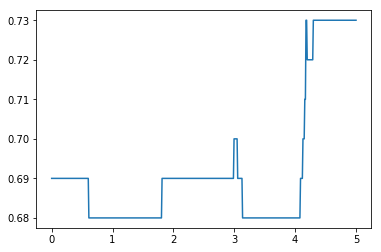

The maximum value of lambda is 4.1783567134268536


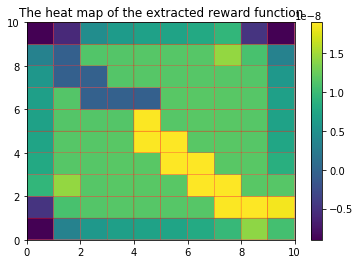

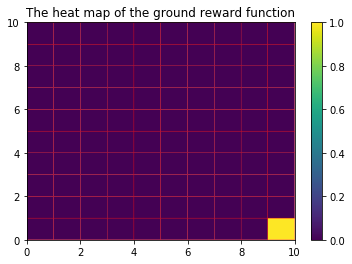

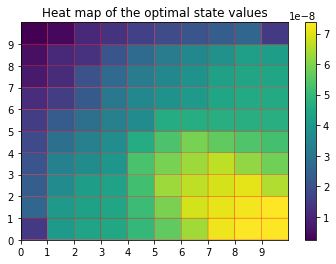

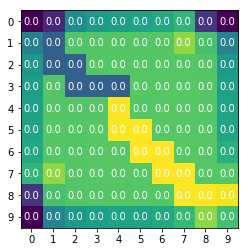

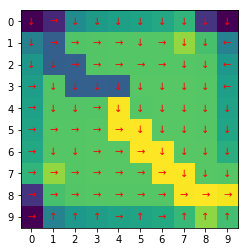

In [16]:
irl(pi_R1,R1)

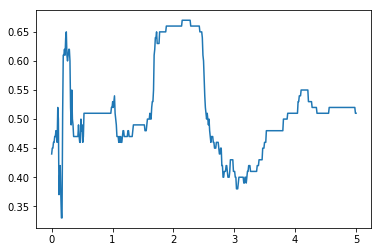

The maximum value of lambda is 2.1442885771543083


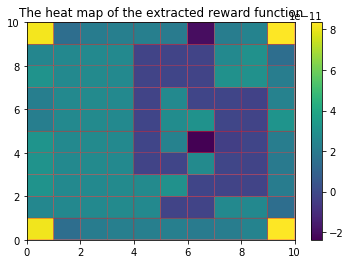

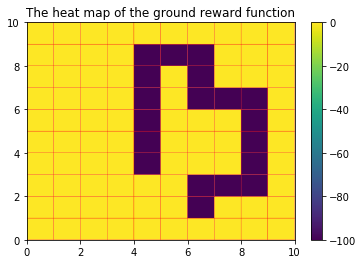

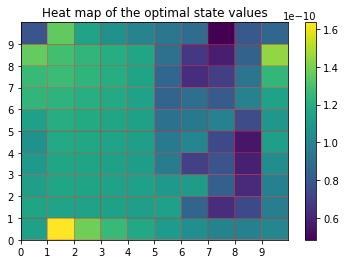

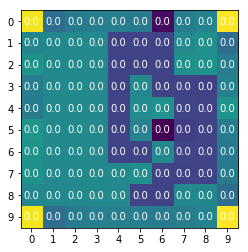

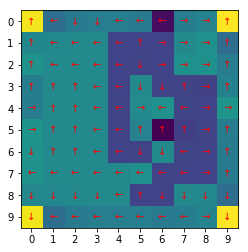

In [17]:
irl(pi_R2,R2)